Title : Spaceship Titanic Survival

Author : Sandra Williams


**In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system. **

train.csv - Personal records for about two-thirds (8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.

People in a group are often family members, but not always.


HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.


CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.


Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.


Destination - The planet the passenger will be debarking to.


Age - The age of the passenger.


VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.


Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


test.csv - Personal records for the remaining one-third (4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.


PassengerId - Id for each passenger in the test set.


Transported - The target. For each passenger, predict either True or False.

In [10]:
# step one is to find the libraries that we will need
# as we have learned is that pandas and numpy is pretty important when it comes to ML

# Libraries we will be using
import pandas as pd
import numpy as np

#this will help us find our plots
import matplotlib.pyplot as plt
import seaborn as sns

# lets used sklearn as well to really dive into our machine learning models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [11]:
import pandas as pd
# lets upload the data from google drive, for the first step
from google.colab import drive
drive.mount('/content/drive')

#first thing to do is to bring the data from python so i just downloaded the csv from kaggle
# and I put it into my drive and uploaded into colab
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')
train.head()


Mounted at /content/drive


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [28]:
#here i am doing some feauture engineering to give my model hints so i am turning
# cabin into deck, number and side to be more specific about my model

def split_cabin(df):
    df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum']= pd.to_numeric(df['CabinNum'], errors='coerce')
    return df

train = split_cabin(train)
test = split_cabin(test)

#TotalSpend is combining all the spending columns because how much you spend can say
#something important about the consumer
spended_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train['TotalSpend'] = train[spended_cols].sum(axis=1)
test['TotalSpend'] = test[spended_cols].sum(axis=1)

In [29]:
#just dropping and renaming some columsn to make it more relevant
target = "Transported"

X = train.drop(columns=["Transported", "Name", "PassengerId", "Cabin"])
y = train[target]

test_ids = test["PassengerId"]
X_test = test.drop(columns=["Name", "PassengerId", "Cabin"])


In [30]:
# this is just helping the model by building a columntransformer + a pipeline
# machine learning models should get rid of any missing values or words
# so building a pipeline to remove any weird messy data is important
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ]
)


In [31]:
# here i am building a randomforest with simple hyperparamters that google recommended me
# for basic ML models but this is basically a group of little decision making trees
# and each tree is making a prediction and the n_estimators is what the paramter is

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',  RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ))
])

In [32]:
# building a basic pipeline, the accuracy score is a .79988499..etc basically a .80 rounding up which
# is definitely not terrible
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

print("Validation Accuracy:", model.score(X_val, y_val))

Validation Accuracy: 0.7998849913743531


In [17]:
preds = model.predict(X_test)

In [18]:
# so we have to create a submission.csv to import to kaggle for the competition
submission = pd.DataFrame({'PassengerId': test_ids, 'Transported': preds})

submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [19]:
# this downloads the submission.csv code from above into a csv
from google.colab import files
files.download('submission.csv')

# submission check

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# After doing some research, I was curious if there is a possibility of increasing the accuracy score a little
# according to StackOverFlow, GridSearchCV uses Cross fold Validation to see which parameters are the most accurate in the model
from sklearn.model_selection import GridSearchCV
param_grid = {
    "classifier__n_estimators": [300,500],
    "classifier__max_depth": [12,16],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2]
}


In [21]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [22]:
grid_search.fit(X_train, y_train)
#grid search is telling us that the best estimator is using the pipeline, if we increase our parameters then theres a chance the accuracy score can improve
# the grid search is telling us that we did 48 models to see which one is the best and is telling us that our pipeline
# Pipeline(
    #preprocessor=
    #cat : SimpleInput --> OneHot Encoder
    #num : SimpleImputer

    #
    # )
    # Classifier = RandomForest
    # )
    # the pipeline is helping us because it is preprocessing non numerical columns and as you know in ML thats how its preferred to run
    # It is also filling missing values with simple imputer and sending clean data to the RandomForestClassifier with the best parameters that grid_search found


Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'], dtype='object')),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImpute...
                                                                         Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'CabinNum', 'TotalSpend'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=12,
                                                               n_estimators=300,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [12, 16],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [300, 500]},
             scoring='accuracy', verbose=2)

In [23]:
# lets do some feature engineering to try to predict our model
def cabin_split(df):
    df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    df['TotalSpend'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    return df

train = cabin_split(train)
test = cabin_split(test)

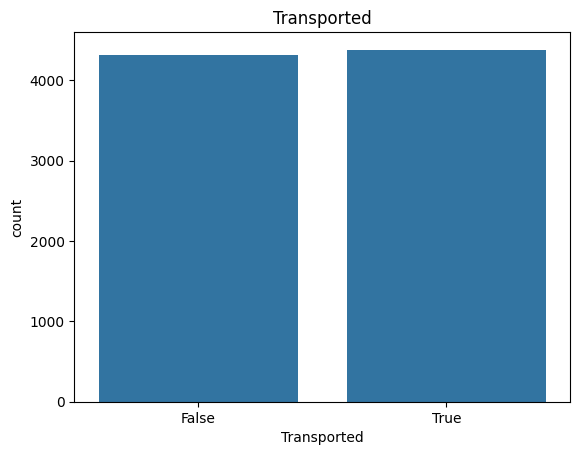

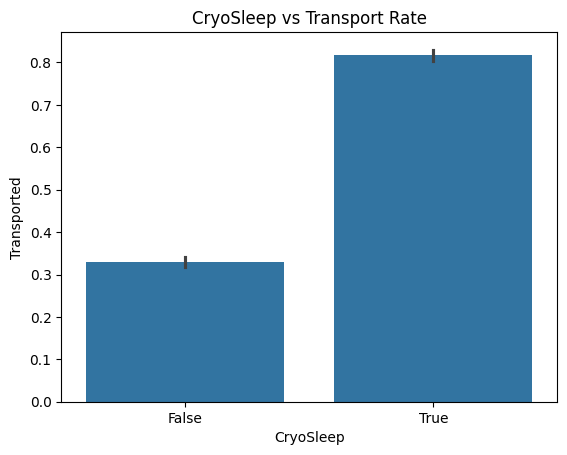

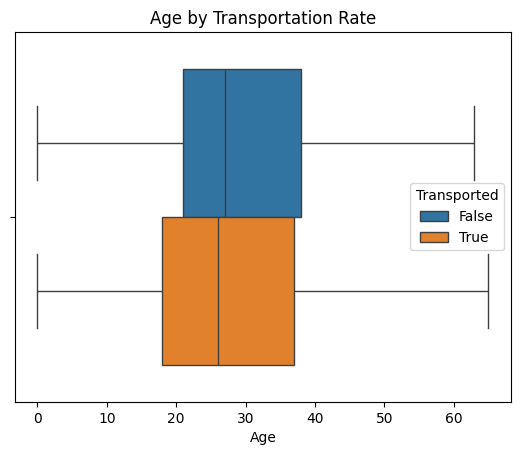

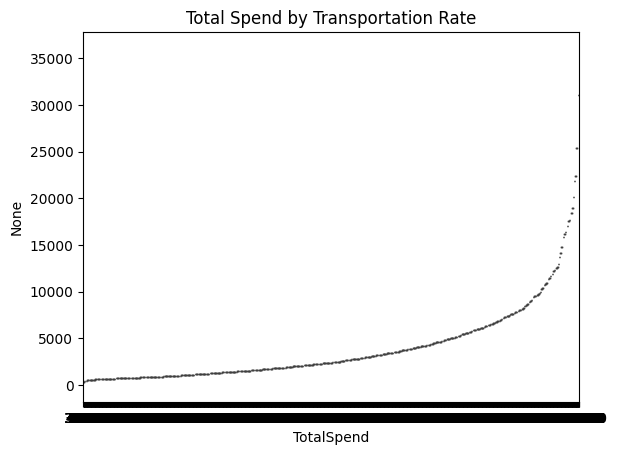

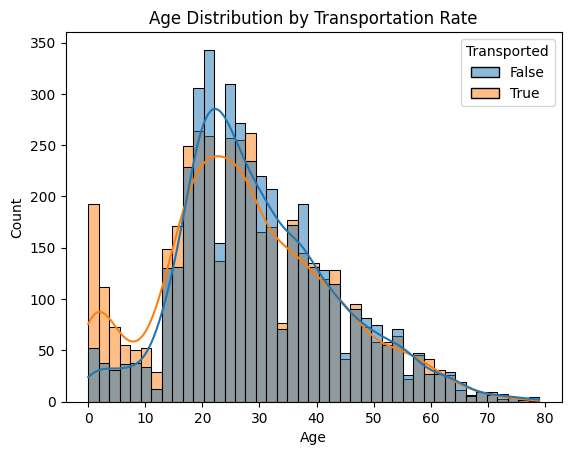

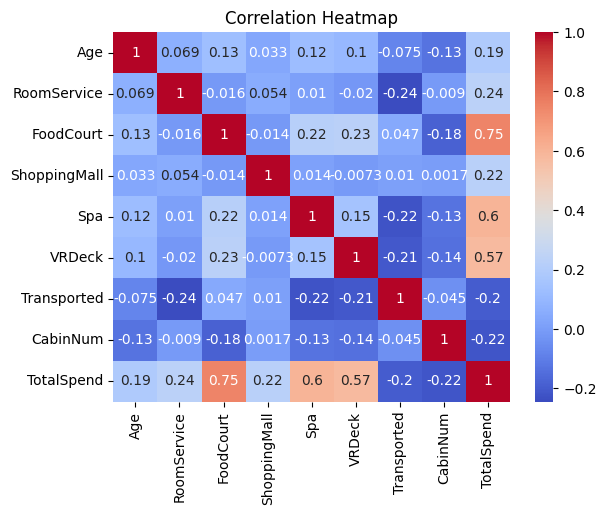

In [24]:
sns.countplot(x=train['Transported'])
plt.title('Transported')
plt.show()

#RESULTS : this barplot is telling me that cryosleep = true and that the transport
#rate is super high at about 80% and when cryosleep is false the transport rate is
#way lower at about 30%
#this shows that cryosleep is the strongest predictor of the dataset
#meaning if you were to sleep during the anomaly, you're more likely to get teleported
sns.barplot(data=train, x='CryoSleep', y='Transported')
plt.title('CryoSleep vs Transport Rate')
plt.show()

#the age boxplot tells us that teens and adults are slightly younger people getting transported
#people who spent more money are less transported because ppl in cryosleep spend $0
#than the ones who were transported
sns.boxplot(data=train, x='Age', hue='Transported', showfliers=False)
plt.title('Age by Transportation Rate')
plt.show()

sns.boxplot(data=train, x='TotalSpend', y=train[['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1))
plt.title('Total Spend by Transportation Rate')
plt.show()

#this is telling us that younger passengers have higher transportation ratesand
# it peaks around ages 0-10
# adults are a mix and older people have a lower transport rate
# seems like the anomaly is more likely to take younger people
# into an alternate dimension
sns.histplot(data=train, x='Age', hue='Transported', kde = True)
plt.title('Age Distribution by Transportation Rate')
plt.show()

#this is a heatmap matrix i found on stack overflow lol
# this matrix is showing you how strong the numeric feautures relate to
# each other
# this is telling us that Food Court & ShoppingMall & Spa & VRDECK
# have a strong correlation with TotalSpend at about .75
#age has no correlation with the spending category meaning that
#just because youre old, people did not spend as much
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#conclusion: the biggest predictors of transported are
#cryosleep, deck, homeplanet, age(younger more likely to do so),
#totalspend(highspend = low transported)

#weaker predictors is that individual spending categories and age is not
#as correlated with anything else
# the model is performing at 79-80% becuase datasets are more likely to cap at 80-82%


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

#model comparison engine
# we are going to test five different models
#logisitc regression, randomforest,KNeighbors Classifier, SVC, and DecisionTree

#model dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(kernel='rbf'),
    "Decision Tree": DecisionTreeClassifier(max_depth=6)
}

#loop to evaluate each model and uses the same preprocessing so each
#comparison gets a fair chance
results = {}

for name, clf in models.items():
  pipe = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', clf)
  ])
  pipe.fit(X_train, y_train)
  preds = pipe.predict(X_val)
  acc = accuracy_score(y_val, preds)
  results[name] = acc
  #this is training each contestant and having them perform and scoring them

  print(f"======{name}=======")
  print(f"Accuracy: {acc}")
  print("Confusion Matrix:", confusion_matrix(y_val, preds))
  print("Classification Report:", classification_report(y_val, preds))
  print("\n---------------------------\n")

  # we should probably convert this to a df rip

  df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
  df_results

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


======Logistic Regression=======
Accuracy: 0.7849338700402531
Confusion Matrix: [[641 220]
 [154 724]]
Classification Report:               precision    recall  f1-score   support

       False       0.81      0.74      0.77       861
        True       0.77      0.82      0.79       878

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.79      0.78      0.78      1739


---------------------------

======Random Forest=======
Accuracy: 0.79700977573318
Confusion Matrix: [[705 156]
 [197 681]]
Classification Report:               precision    recall  f1-score   support

       False       0.78      0.82      0.80       861
        True       0.81      0.78      0.79       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


---------------------------

======KNN=======
Accuracy: 0.7538815411155

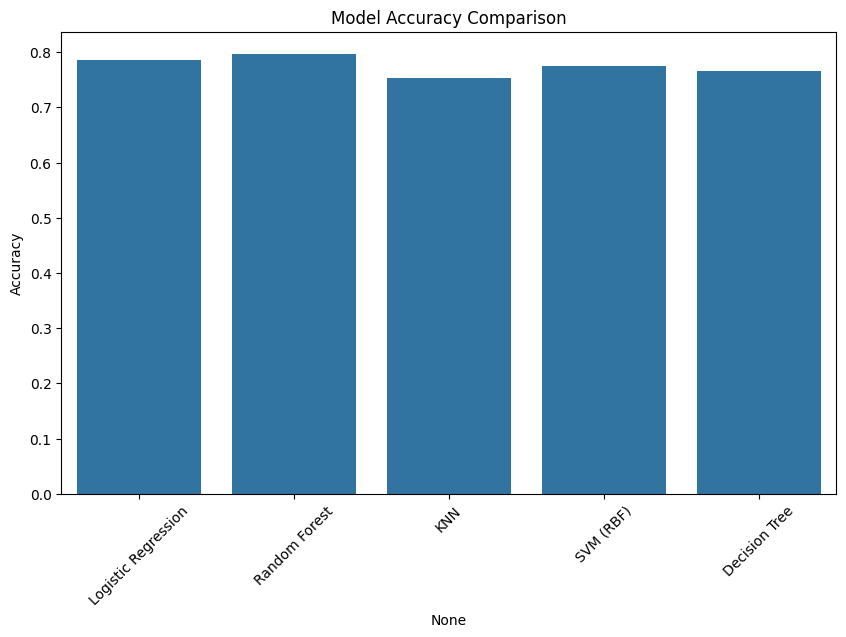

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=df_results.index, y=df_results['Accuracy'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

What we see above is each training model that we did. For each of the training models we used, we got accuracy score, confusion matrix and a classification report. This means that the accuracy score with the highest accuracy which is 80% was RandomForest which shows that there is a strong predictive performance.

The classification reports show balanced and recall across both classes, meaning the model performed consistently for predicting transported and non-transported.

The misclassification erros compared to other models in RandomForest was lower compared to other models.

Conclusion: RandomForest is the best performing model maybe because it caputres the ability to capture nonlinear patterns.

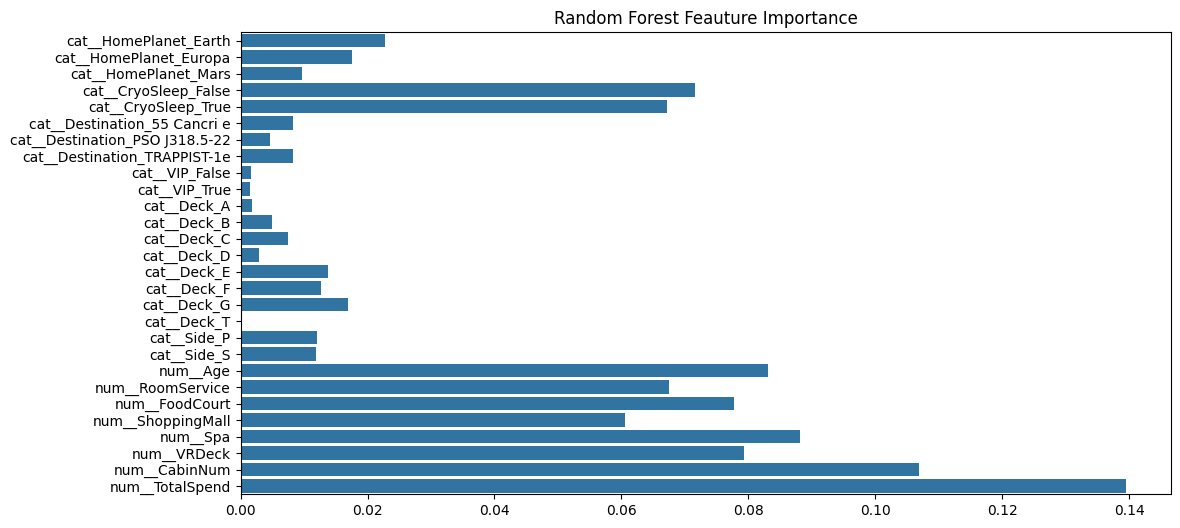

In [42]:
#RandomForest Importance Chart
best_rf = RandomForestClassifier(n_estimators=300, max_depth=12)
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_rf)
])
rf_model.fit(X_train, y_train)

#feature names
feauture_names = rf_model.named_steps['preprocessor'].get_feature_names_out()
importances = rf_model.named_steps['classifier'].feature_importances_

#plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=feauture_names)
plt.title("Random Forest Feauture Importance")
plt.show()

#results: this RandomForest importance chart will show us whats the
#most important featurues in the model which shows that cryosleep is the main predictor
#and total spend is carrying the dataset.
#note: the longer the bar the more influence it has

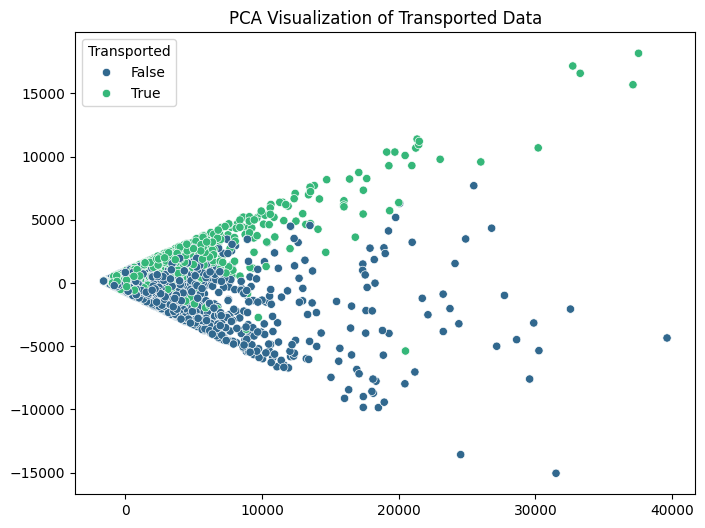

In [44]:
#PCA Visualizaion -- PLOT component analysis (i didnt know what PCA meant so i googled it)
# PCA is taking 40+ featurues like homeplanet, age, etc and squishing them into PC1 and PC2
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(preprocessor.fit_transform(X))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title('PCA Visualization of Transported Data')
plt.show()

#just showing the strongest patterns in the model

In [ ]:
# the greenpoint = true which tend to cluster towards the upper region of the plot
# bluepoints = false which is clustering towards the lower half
# this is helping us see that there is a real pattern in the data to predict transporation\
#this also helps us see why are model is performing at 80% because there is a clear structure since there is
#clear color gradients, and groups are not identical and theres no splitting
# PCA is a sphere like shape so that means that it is varying in one dimension
#PC1 = total spending + cryosleep, PC2 = age + cabin info
# conclusion: some passengers vary massively in spending or cryosleep behavior which is the reason it gives us this shape
# you can also see that there dots are starting to mix in the middle which shows us why it is not at 90% or 95% aka the classes are not perfectly seperable
#human behavior has randomness!!!!!!!

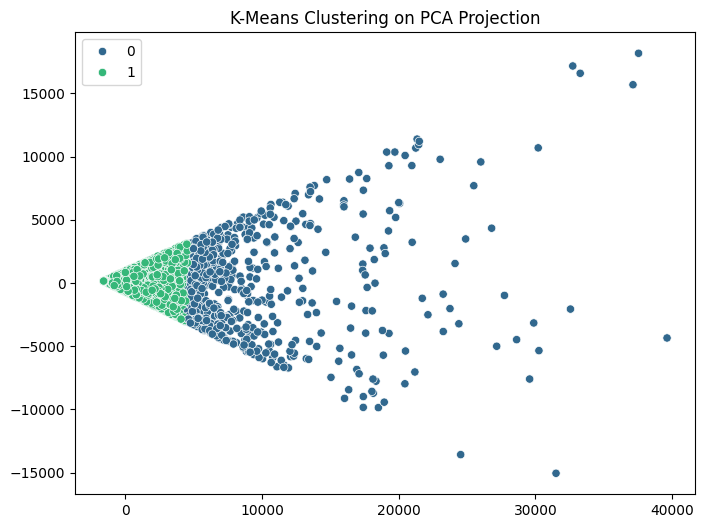

In [45]:
#K-Means Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(preprocessor.fit_transform(X))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title("K-Means Clustering on PCA Projection")
plt.show()

K-Means in this model is very confused and contains one compact region which is the green region which is of high similarity. This is showing us that the structure of the data is not really matching the actual transported/not transported labels. Therefore the transportation outcomes requires more supervision since unsupervised clustering fails

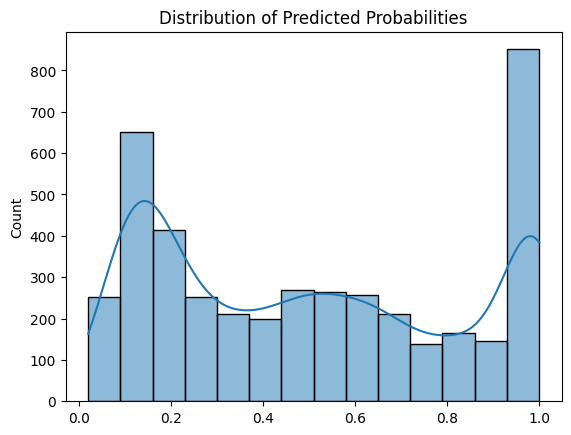

In [46]:
probs = rf_model.predict_proba(X_test)[:, 1]
#this above is just saying that as it nears 1.0 the model
#is going to be very sure the passenger will be transported and when it nears
#0 then the passenger will not be transported.
#Values near 0.5 shows the model is confused and probably unsure

sns.histplot(probs, kde=True)
plt.title("Distribution of Predicted Probabilities")
plt.show()

#the histogram should show us how confident our model is

The distribution of the model is pretty good because they have strong peaks at 0 and 1. This shows us that our model is pretty okay since it is not close to 0.5. Only a small portion of smaples fall near the 0.4-0.6 range which shows that due to human randomness, the model is seeing that there is a mix of thoughts/confusion.